# Exploring Visual Language Models: PaliGemma

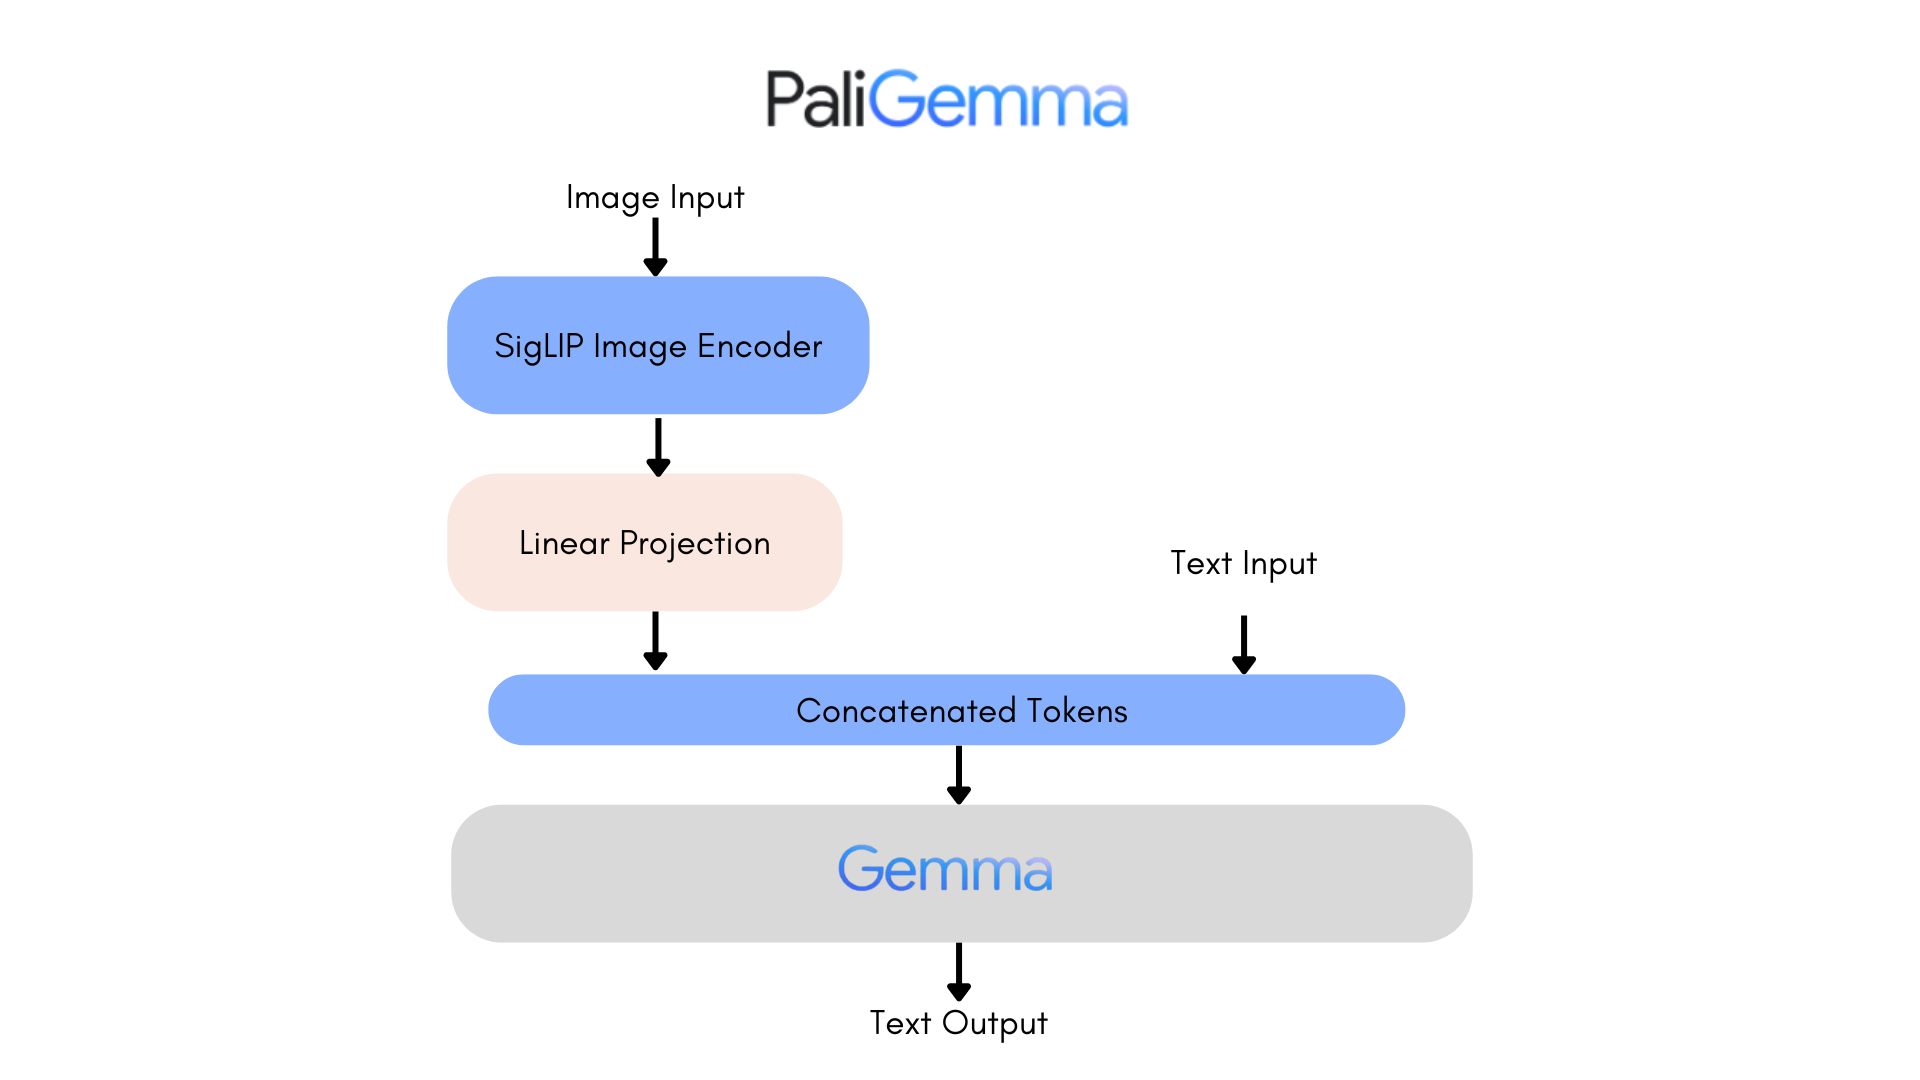

## Login and accept HuggingFace Terms

PaliGemma requires users to accept Gemma license. Go to HF Gemma repo and ask for access. To login to Hugging Face Hub create an access token and copy into the cell below. The token must have the following permissions:

*   Read access to contents of all public gated repos you can access
*   Make calls to the serverless Inference API
*   Make calls to Inference Endpoints



In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()
import os
from google.colab import userdata
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

## Libraries

In [ ]:
%pip install -q -U accelerate bitsandbytes git+https://github.com/huggingface/transformers.git gradio

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests, torch, os, glob, re
from transformers import AutoTokenizer, PaliGemmaForConditionalGeneration, PaliGemmaProcessor
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def prompt_paligemma(text, input_image):
    inputs = processor(text=text, images=input_image, padding="longest", do_convert_rgb=True, return_tensors="pt").to(device)
    inputs = inputs.to(dtype=model.dtype)
    with torch.no_grad():
        output = model.generate(**inputs, max_length=496)
    return processor.decode(output[0], skip_special_tokens=True)

def read_categories(base_path):
    categories = {}
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        if os.path.isdir(folder_path):
            images = glob.glob(os.path.join(folder_path, '*'))
            images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'))]
            categories[folder_name] = len(images)

    for category, count in categories.items():
        print(f"Categories: {category}, Num of images: {count}")
    return categories

def parse_bbox_and_labels(detokenized_output: str):
    matches = re.finditer(
        r'<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>'
        r' (?P<label>.+?)( ;|$)',
        detokenized_output,
    )
    labels, boxes = [], []
    fmt = lambda x: float(x) / 1024.0
    for m in matches:
        d = m.groupdict()
        boxes.append([fmt(d['y0']), fmt(d['x0']), fmt(d['y1']), fmt(d['x1'])])
        labels.append(d['label'])
    return np.array(boxes), np.array(labels)

def display_boxes(image, boxes, labels, target_image_size):
    h, l = target_image_size
    fig, ax = plt.subplots()
    ax.imshow(image)
    for i in range(boxes.shape[0]):
        y0, x0, y1, x1 = (boxes[i] * [h, l, h, l]).astype(int)
        width = x1 - x0
        height = y1 - y0
        rect = patches.Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
        # Add label
        plt.text(x0, y0, labels[i], color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
        ax.add_patch(rect)
    plt.axis('off')
    plt.show()


## Load model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
tag = "google/paligemma-3b-mix-224"
model = PaliGemmaForConditionalGeneration.from_pretrained(tag, torch_dtype=torch.float32)
processor = PaliGemmaProcessor.from_pretrained(tag)
model.to(device)

cuda


/usr/local/lib/python3.10/dist-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 

## Perform an Inference: Caption

In [ ]:
base_path = '/content/drive/MyDrive/Google_IO/datasets'
categories = read_categories(base_path)

Categories: futbol, Num of images: 3
Categories: ropa, Num of images: 9
Categories: botero, Num of images: 3
Categories: trafico, Num of images: 2


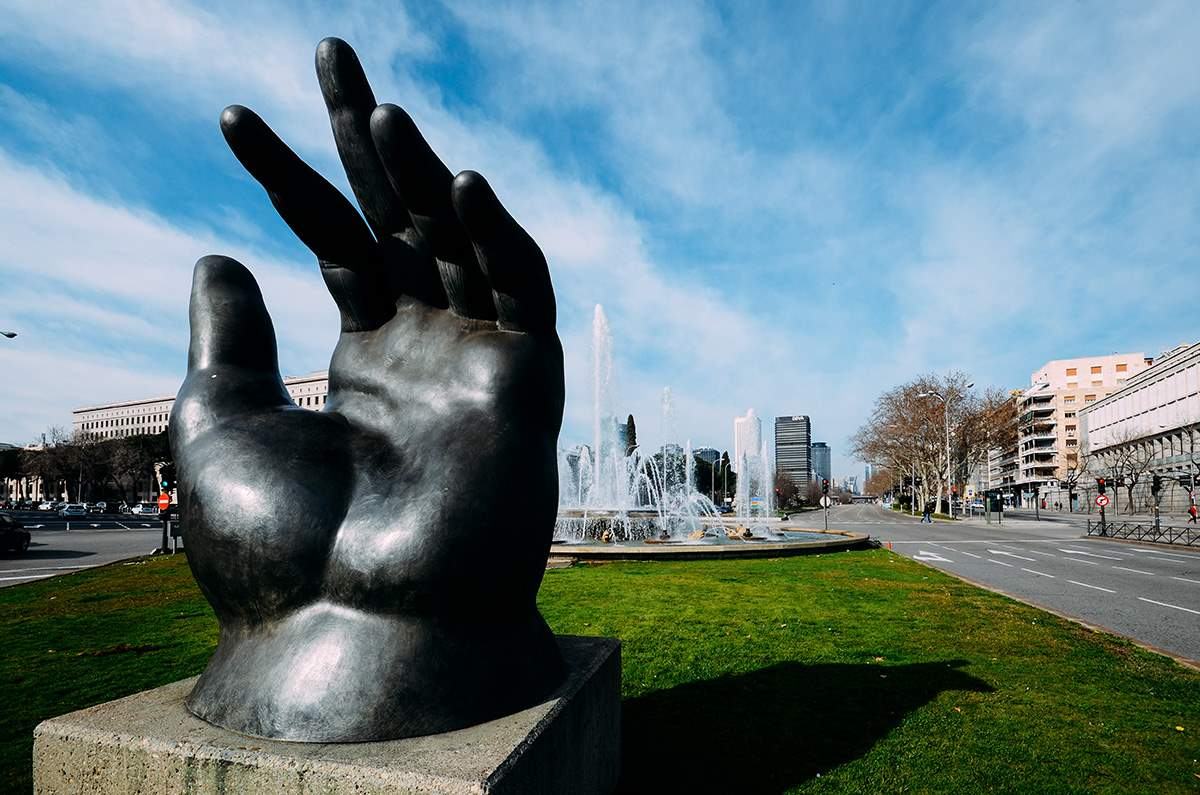

In [ ]:
category = os.path.join(base_path, 'botero')
category_image = glob.glob(os.path.join(category, '*'))[1]
input_image = Image.open(category_image)
input_image

In [ ]:
prompt = "caption"
result = prompt_paligemma(prompt, input_image)
print(result)

caption
In this image we can see a statue of a hand, there are some buildings, trees, poles, vehicles, there is a fountain, also we can see the sky.


## Perform an Inference: Q&A

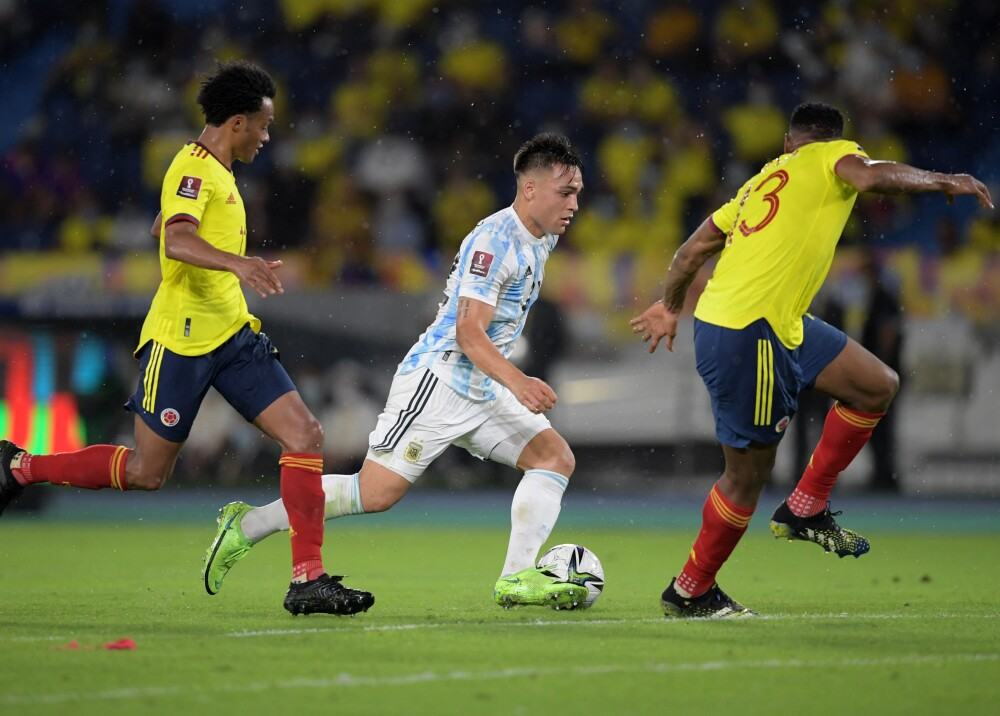

In [ ]:
category = os.path.join(base_path, 'futbol')
category_image = glob.glob(os.path.join(category, '*'))[2]
input_image = Image.open(category_image)
input_image

In [ ]:
prompt = "Qué equipo tiene el balon?"
result = prompt_paligemma(prompt, input_image)
print(result)

Qué equipo tiene el balon?
argentina


## Perform an Inference: Object Detection

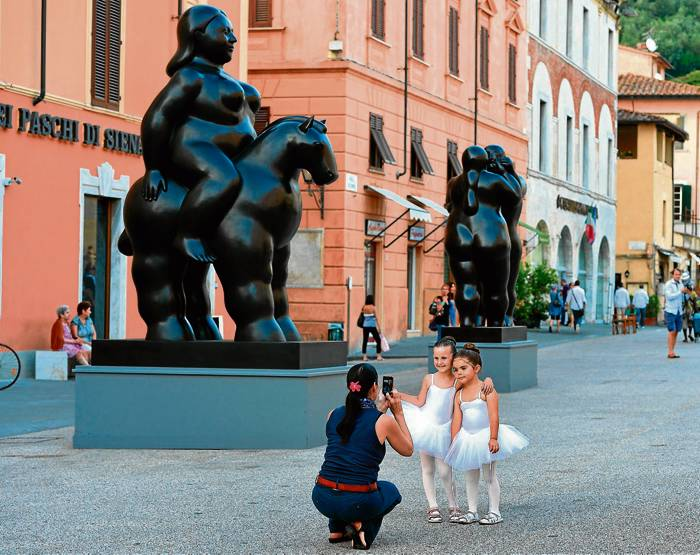

In [ ]:
category = os.path.join(base_path, 'botero')
category_image = glob.glob(os.path.join(category, '*'))[2]
input_image = Image.open(category_image)
input_image

In [ ]:
prompt = "detect girl"
detokenized_output = prompt_paligemma(prompt, input_image)
boxes, labels = parse_bbox_and_labels(detokenized_output)
if len(labels)>0:
  target_image_size = input_image.size
  display_boxes(input_image, boxes, labels, target_image_size)
else:
  print("No label available")

## Perform an Inference: Segmentation

In [ ]:
base_path = '/content/drive/MyDrive/Google_IO/datasets'
categories = read_categories(base_path)

Categories: futbol, Num of images: 3
Categories: ropa, Num of images: 9
Categories: botero, Num of images: 3
Categories: trafico, Num of images: 2


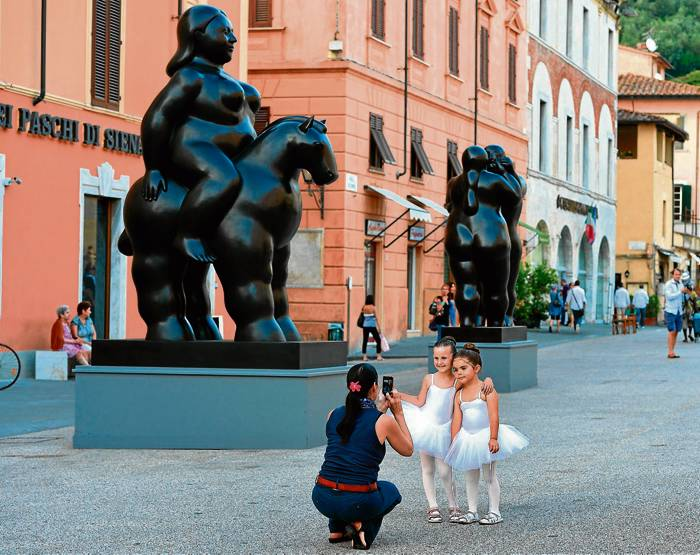

In [ ]:
category = os.path.join(base_path, 'botero')
category_image = glob.glob(os.path.join(category, '*'))[2]
input_image = Image.open(category_image)
input_image

In [ ]:
prompt = "Que obra de arte hay?"
prompt_paligemma(prompt, input_image)

Que obra de arte hay?
la obra de arte es una escultura de un caballo y una mujer.
